# Pyruvate Metabolism Subsystem

Set the model environment

In [1]:
import cobra
import pandas as pd
import numpy as np
import pandas as pd
import escher
from escher import Builder
from cobra.sampling import sample
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 5000)
pd.set_option('display.width',1000)
pd.set_option('display.max_colwidth',None)
model = cobra.io.load_json_model('./e_coli_core.json') # Model must be in the same directory

The pyruvate metabolism subsystem contains the reactions required for fermentation. Fermentation is the process of extracting energy from the oxidation of organic compounds without oxygen. The location of the fermentation reactions on the *E.coli* core map are shown in the Figure 1.

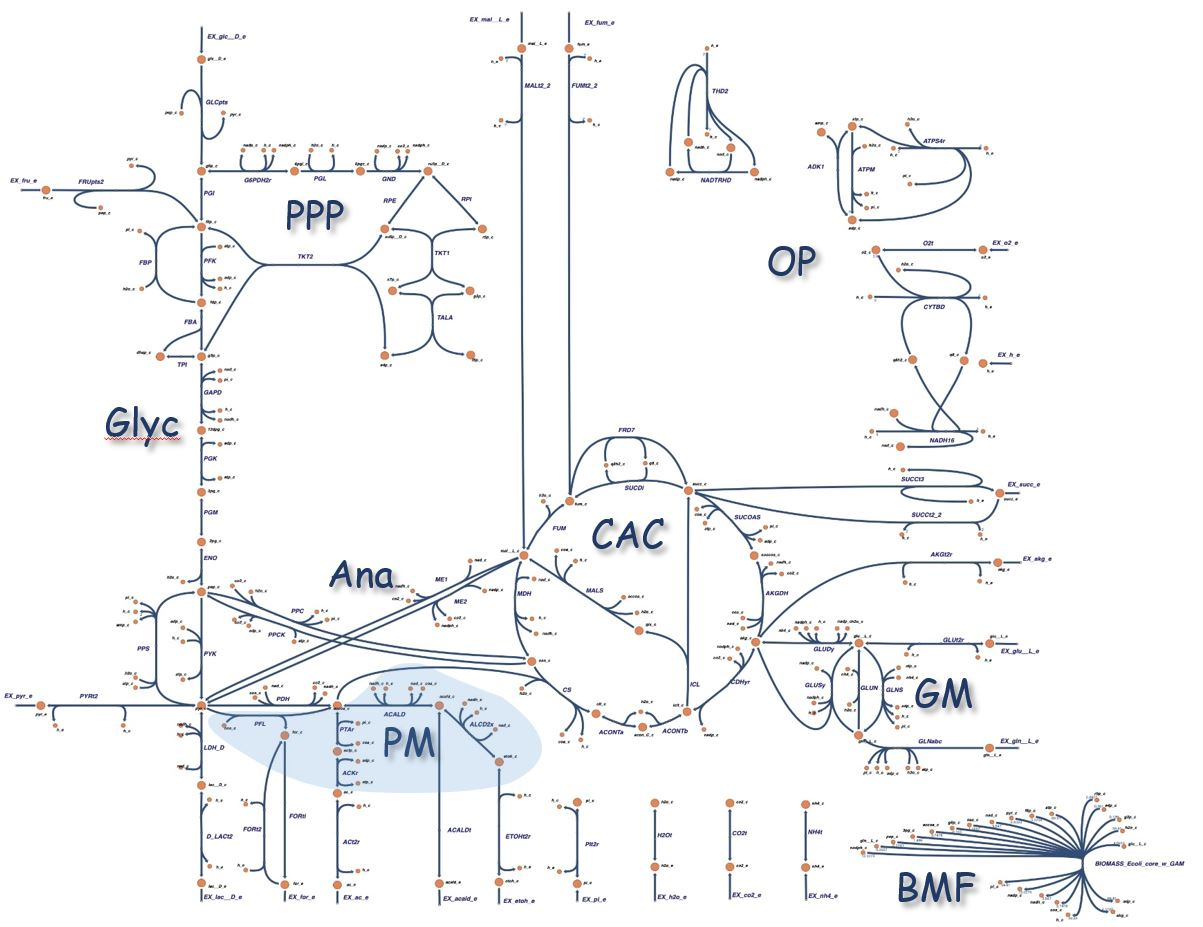

Figure 1. The pyruvate metabolism reactions highlighted in blue on the E.coli core map [3].

The reactions associated with the pyruvate metabolism subsystem pathways include:

In [2]:
reaction_names = [r.name for r in model.reactions]
reaction_ids = [r.id for r in model.reactions]
reaction_formula = [r.reaction for r in model.reactions]
reaction_subsystem = [r.subsystem for r in model.reactions]
reactionList = {'Reaction ID': reaction_ids,
                'Reaction Name': reaction_names,
                'Reaction Formula': reaction_formula,
                'Reaction Subsystem': reaction_subsystem,
               }

df = pd.DataFrame(reactionList, columns= ['Reaction ID','Reaction Name','Reaction Formula','Reaction Subsystem'])
# Select the reactions associated with the desired subsystem
SSindex = []
for i in range(len(reaction_subsystem)):
    if reaction_subsystem[i] == 'Pyruvate Metabolism':
        SSindex.append(i)
df.loc[SSindex]

,Reaction ID,Reaction Name,Reaction Formula,Reaction Subsystem
1,PFL,Pyruvate formate lyase,coa_c + pyr_c --> accoa_c + for_c,Pyruvate Metabolism
5,ACALD,Acetaldehyde dehydrogenase (acetylating),acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c,Pyruvate Metabolism
9,ALCD2x,Alcohol dehydrogenase (ethanol),etoh_c + nad_c <=> acald_c + h_c + nadh_c,Pyruvate Metabolism
11,ACKr,Acetate kinase,ac_c + atp_c <=> actp_c + adp_c,Pyruvate Metabolism
22,PTAr,Phosphotransacetylase,accoa_c + pi_c <=> actp_c + coa_c,Pyruvate Metabolism
84,LDH_D,D-lactate dehydrogenase,lac__D_c + nad_c <=> h_c + nadh_c + pyr_c,Pyruvate Metabolism


The reactions, GRPA relationships, and precursors for this section on fermentation are shown in Figure 2 below.

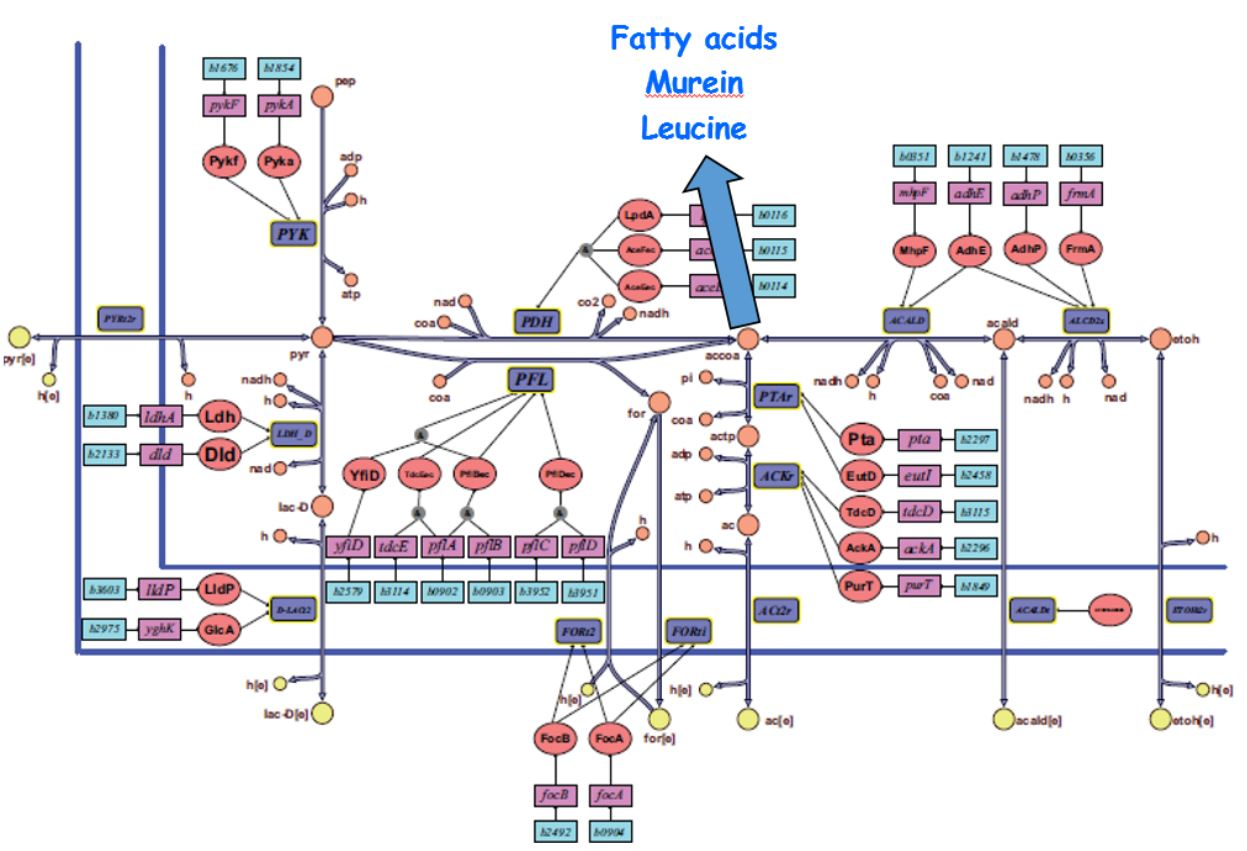

            Figure 27. Reactions, GRPA relationships, and precursors for the pyruvate metabolism [1].

During aerobic respiration, oxygen is used as the terminal electron acceptor for the oxidative phosphorylation process yielding the bulk of atp_c required for cells biosynthesis. Anaerobic respiration, on the other hand, refers to respiration without molecular oxygen. In this case, E. coli can only generate atp_c through substrate level phosphorylation which significantly reduces the amount of atp_c that can be produced per molecule of glucose. In anaerobic conditions, glycolysis results in the net production of 2 atp_c per glucose by substrate level phosphorylation. This is compared to the total of 17.5 atp_c per glucose molecule that can be produced for aerobic respiration [1]. To maintain the necessary energy needed for cellular operation during anaerobic growth, this forces each cell to maintain a large magnitude of flux through the glycolysis pathway to generate the necessary atp_c to meet the cells growth requirements. This results in a large magnitude efflux of fermentative end products (lactate(lac__D_c), formate (for_c), acetate (ac_c), acetaldehyde (acald_c), and ethanol (etoh_c)) since there is insufficient atp_c to assimilate all the carbon into biomass. It should be pointed out that only ~10% of carbon substrate is effectively assimilated into the cell due to the poor energy yield of fermentation.

There are two main fermentive processes included in the core model; homolactic fermentation and mixed acid fermentation. Homolactic fermentation refers to the conversion of pyruvate to lactate as shown on the bottom left of Figure 26 and includes the reactions LDH_D and D_LACt2 . Mixed acid fermentation is the process that converts pyrvate into a mixture of end products including lactate, acetate, succinate, formate, ethanol and includes the following reactions; PDH, PFL, FORti, FORt2, PTAr, ACKr, ACALD, ALCD2x, ACt2r, ACALDt, and ETOHt2r. It should also be pointed out that the end products of each fermentation pathway, with the exception of acetaldehyde, exit the cell along a concentration gradient and transport a proton from the cytoplasm into the extracellular space.

Let's begin our exploration of the fermentation metabolism by determining the secreted bioproducts produced in anaerobic conditions with a glucose carbon source.

In [3]:
model = cobra.io.load_json_model('./e_coli_core.json')
# Set the inputs
model.reactions.EX_o2_e.lower_bound = -0 # Aerobic condition
model.reactions.EX_glc__D_e.lower_bound = -10
# Optimize
Glucose_aerobic_flux = model.optimize()
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


With these results we can see that acetate, ethanol, and formate are the mixed fermentation products. The following Escher map shows the cell in this anaerobic condition. Note the flux flow in the paths of the secreted mixed acid fermentation products. 

In [4]:
builder = Builder(
    map_name='e_coli_core.Core metabolism', 
    model_name='e_coli_core', 
)
builder

Builder()

In [5]:
builder.reaction_data = Glucose_aerobic_flux.fluxes

The active reactions include

In [6]:
nz = Glucose_aerobic_flux.fluxes
nz = nz.replace(0, np.nan)
nz = nz.dropna(how='all', axis=0)
nz

PFK                         9.789459e+00
PFL                         1.780467e+01
PGI                         9.956609e+00
PGK                        -1.943734e+01
ACALD                      -8.279455e+00
PGM                        -1.912069e+01
PIt2r                       7.786445e-01
ALCD2x                     -8.279455e+00
ACKr                       -8.503585e+00
PPC                         6.065413e-01
ACONTa                      2.283632e-01
ACONTb                      2.283632e-01
ATPM                        8.390000e+00
ACt2r                      -8.503585e+00
ATPS4r                     -5.452053e+00
PTAr                        8.503585e+00
PYK                         8.404273e+00
BIOMASS_Ecoli_core_w_GAM    2.116629e-01
CO2t                        3.781782e-01
RPE                        -1.521433e-01
CS                          2.283632e-01
RPI                        -1.521433e-01
CYTBD                       3.552714e-15
ENO                         1.912069e+01
SUCCt3          

Now let's explore the producers and consumers of atp_c in anaerobic conditions with a glucose carbon source.

In [7]:
model.metabolites.atp_c.summary()

Percent,Flux,Reaction,Definition
23.40%,8.504,ACKr,ac_c + atp_c <=> actp_c + adp_c
53.48%,19.44,PGK,3pg_c + atp_c <=> 13dpg_c + adp_c
23.12%,8.404,PYK,adp_c + h_c + pep_c --> atp_c + pyr_c
Percent,Flux,Reaction,Definition
23.08%,-8.39,ATPM,atp_c + h2o_c --> adp_c + h_c + pi_c
15.00%,-5.452,ATPS4r,adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c
34.83%,-12.66,BIOMASS_Ecoli_core_w_GAM,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
0.15%,-0.05412,GLNS,atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c
26.93%,-9.789,PFK,atp_c + f6p_c --> adp_c + fdp_c + h_c


Note that all the atp_c is produced through substrate phosphorylation through PGK and PYK in the glycolysis pathway and ACKr in the fermentation pathway that produces acetate. Now let's check to see if the majority of the produced nadh_c is reduced to nad_c by the fermentation pathways.

In [8]:
model.metabolites.nadh_c.summary()

Percent,Flux,Reaction,Definition
3.72%,0.7508,BIOMASS_Ecoli_core_w_GAM,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
96.28%,19.44,GAPD,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
Percent,Flux,Reaction,Definition
41.01%,-8.279,ACALD,acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c
41.01%,-8.279,ALCD2x,etoh_c + nad_c <=> acald_c + h_c + nadh_c
17.98%,-3.629,THD2,2.0 h_e + nadh_c + nadp_c --> 2.0 h_c + nad_c + nadph_c


In this case we can see that the nadh_c produced in the glycolysis pathway is either oxidized to nad_c in the ethanol pathway (ACALD, ALCD2x) or converted to nadph_c for cell biosynthesis through the oxidative phosphorylation subsystem reactions (THD2).

Now let's expore the impact of pyruvate as the carbon sources in an anaerobic environment. 

In [9]:
model = cobra.io.load_json_model('./e_coli_core.json')
# Set the inputs
model.reactions.EX_o2_e.lower_bound = -0 # Aerobic condition
model.reactions.EX_glc__D_e.lower_bound = -0
model.reactions.EX_pyr_e.lower_bound = -20
# Optimize
Pyruvate_aerobic_flux = model.optimize()
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
h2o_e,EX_h2o_e,18.57,0,0.00%
nh4_e,EX_nh4_e,0.3574,0,0.00%
pi_e,EX_pi_e,0.2411,0,0.00%
pyr_e,EX_pyr_e,20,3,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-19,2,66.43%
co2_e,EX_co2_e,-0.9484,1,1.66%
for_e,EX_for_e,-18.25,1,31.91%
h_e,EX_h_e,-18.57,0,0.00%


The Escher map

In [10]:
builder2 = Builder(
    map_name='e_coli_core.Core metabolism', 
    model_name='e_coli_core', 
)
builder2

Builder()

In [11]:
builder2.reaction_data = Pyruvate_aerobic_flux.fluxes

From this map we can see that as the pyruvate enters the cell, part of the flux is directed upward through the glycolysis pathway (gluconeogenesis) to the pentose phosphate pathway to create the 4-, 5- and 7-carbon precursors. Part of the flux is also directed to the TCA cycle to feed the nitrogen metabolism, with the remaining flux being directed through the fermentation pathways to produce formate, acetate, and some atp_c through substrate phosphorylation. 

The active reaction flux values for this condition are calculated below.

In [12]:
nz2 = Pyruvate_aerobic_flux.fluxes
nz2 = nz2.replace(0, np.nan)
nz2 = nz2.dropna(how='all', axis=0)
nz2

PFL                         1.825466e+01
PGI                        -1.343617e-02
PGK                         1.742311e-01
PGL                        -5.111412e-15
PGM                         2.722823e-01
PIt2r                       2.411104e-01
ALCD2x                      3.399712e-15
ACKr                       -1.900386e+01
PPC                         1.878180e-01
ACONTa                      7.071357e-02
ACONTb                      7.071357e-02
ATPM                        8.390000e+00
ACt2r                      -1.900386e+01
PPS                         4.941233e-01
ADK1                        4.941233e-01
ATPS4r                     -5.514535e+00
PTAr                        1.900386e+01
BIOMASS_Ecoli_core_w_GAM    6.554228e-02
PYRt2                       2.000000e+01
CO2t                       -9.484427e-01
RPE                        -4.711179e-02
CS                          7.071357e-02
RPI                        -4.711179e-02
CYTBD                       2.122746e-13
ENO             

# References

1. Orth, Fleming, and Palsson (2010), EcoSal Chapter 10.2.1 - Reconstruction and Use of Microbial Metabolic Networks: the Core Escherichia coli Metabolic Model as an Educational Guide

